<a href="https://colab.research.google.com/github/saleh1312/GAN/blob/main/srgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras.layers as lay
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K
from keras.layers.advanced_activations import LeakyReLU
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


In [2]:
from tensorflow.keras.applications.vgg19 import preprocess_input

preprocess data
and load it

In [3]:
hr=np.load('/content/drive/MyDrive/da/hr.npy')
lr=np.load('/content/drive/MyDrive/da/lr.npy')

In [50]:
BUFFER_SIZE = 96
batch = 3

In [5]:
hr=hr.astype(np.float32)/255.0
lr=lr.astype(np.float32)/255.0

create models


In [6]:
#vgg
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

80142336/80134624 [==============================] - 0s 0us/step


In [35]:
layer_names=['block4_conv2',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

outputs = [vgg.get_layer(name).output for name in layer_names]
con_vgg=Model([vgg.input], outputs)

In [8]:
#generator
input=lay.Input(shape=(512,1048,3))
c1=lay.Conv2D(3,(5,5),(1,1),padding='same',activation='relu')(input)
gino = Model([input],c1)

In [9]:
#discriminator
inputd=lay.Input(shape=(512,1048,3))
c1d=lay.Conv2D(3,(5,5),(1,1),padding='same',activation='relu')(inputd)
c3d=lay.Flatten()(c1d)
c5d=lay.Dense(1,activation='sigmoid')(c3d)
diso = Model([inputd],c5d)

In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [43]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def gram_matrix(tensor):
  temp = tensor
  temp = tf.squeeze(temp)
  fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
  result = tf.matmul(temp, temp, transpose_b=True)
  gram = tf.expand_dims(result, axis=0)
  return gram

In [33]:
def generator_loss(sr,hr,diso_preds):

    loss_content= 0
    loss_style=0
    for i in range(0,batch):

      s=sr[i][tf.newaxis, :]
      s=preprocess_input(s*255.0)
      content_sr=con_vgg(s)

      content_sr_outputs,style_sr_outputs = (content_sr[0],
                                      content_sr[1:])
      
      gram_sr_content =gram_matrix(content_sr_outputs)


      gram_sr_style = [gram_matrix(style) for style in style_sr_outputs]
     

      h=hr[i][tf.newaxis, :]
      h=preprocess_input(h*255.0)
      content_hr=con_vgg(h)

      content_hr_outputs,style_hr_outputs = (content_hr[0],
                                      content_hr[1:])

      
      gram_hr_content=gram_matrix(content_hr_outputs)

      gram_hr_style = [gram_matrix(style) for style in style_hr_outputs]


      content_loss=tf.reduce_mean((gram_sr_content-gram_hr_content)**2)

      for gram_sr,gram_hr in zip(gram_sr_style,gram_hr_style):
          style_loss=tf.reduce_mean((gram_sr-gram_hr)**2)
          loss_style=loss_style+style_loss

      loss_content=loss_content+content_loss


    adversial_loss=cross_entropy(tf.ones_like(diso_preds), diso_preds)
    total=loss_content+adversial_loss+loss_style
    
    return total

In [15]:
def train(epochs=10):
  
  for e in range(epochs):
    g_loss=0
    d_loss=0
    
    for i in range(0,96,batch):
      
      idx=np.arange(i,i+batch)
      hrs = hr[idx]
      lrs = lr[idx]
   
      g,d=train_step(hrs,lrs)
      g_loss=g_loss+g
      d_loss=d_loss+d
    print('epoch: '+str(e+1)+' g loss: '+str(tf.keras.backend.get_value(g_loss))+' d loss: '+str(tf.keras.backend.get_value(d_loss)))
      

In [16]:
def train_step(hrs,lrs):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        srs = gino(lrs, training=True)

        real_output = diso(hrs, training=True)
        fake_output = diso(srs, training=True)

        gen_loss = generator_loss(srs,hrs,fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gino.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, diso.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, gino.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, diso.trainable_variables))
    return gen_loss,disc_loss


In [53]:
train(100)

epoch: 1 g loss: 8.684643e+17 d loss: 0.004657587
epoch: 2 g loss: 8.684368e+17 d loss: 0.0046496196
epoch: 3 g loss: 8.682952e+17 d loss: 0.004641944
epoch: 4 g loss: 8.681592e+17 d loss: 0.004634392
epoch: 5 g loss: 8.68035e+17 d loss: 0.0046269395
epoch: 6 g loss: 8.679099e+17 d loss: 0.004619576
epoch: 7 g loss: 8.677797e+17 d loss: 0.0046122293
epoch: 8 g loss: 8.676539e+17 d loss: 0.0046050255
epoch: 9 g loss: 8.675306e+17 d loss: 0.0045976765
epoch: 10 g loss: 8.6740623e+17 d loss: 0.0045902585
epoch: 11 g loss: 8.672932e+17 d loss: 0.0045829266
epoch: 12 g loss: 8.671719e+17 d loss: 0.004575725
epoch: 13 g loss: 8.670559e+17 d loss: 0.0045686895
epoch: 14 g loss: 8.669391e+17 d loss: 0.0045617307


KeyboardInterrupt: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


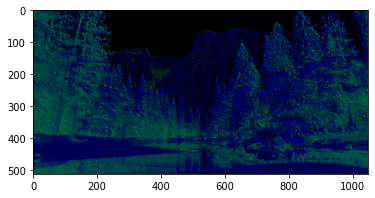

In [54]:
s=lr[6][tf.newaxis, :]
y=np.reshape((gino.predict(s)),(512,1048,3))
y=cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
plt.imshow(y)

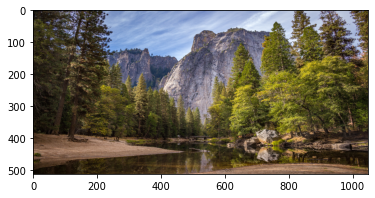

In [48]:
h=cv2.cvtColor(hr[6], cv2.COLOR_BGR2RGB)
plt.imshow(h)